### 0. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import minimize 

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, PoissonRegressor, LinearRegression

import sys
sys.path.append('/home/rachel/Documents/lfp2spikes/modularized_code') 
from models.GLM import GLM, LNL_POISSON
from models.fit_model import MODEL_FITTING
#from experiment_setup.experiment_setup import DATA_PREP

In [2]:
rc = {
    'text.usetex'          : False,
    'font.family'          : 'serif',
    'font.serif'           : 'Arial, sans-serif',
    'font.sans-serif'      : 'Arial, sans-serif',
    'font.cursive'         : 'Arial, sans-serif',
    'font.size'            : 12,
    'legend.fontsize'      : 12,
    'axes.labelsize'       : 12,
    'xtick.labelsize'      : 12,
    'ytick.labelsize'      : 12,

    'image.interpolation'   : 'nearest',
    'image.resample'        : False,
    'image.composite_image' : True,

    'axes.spines.left'     : True,
    'axes.spines.bottom'   : True,
    'axes.spines.top'      : False,
    'axes.spines.right'    : False,

    'axes.linewidth'       : 1.5,
    'xtick.major.width'    : 1.5,
    'xtick.minor.width'    : 1.5,
    'ytick.major.width'    : 1.5,
    'ytick.minor.width'    : 1.5,

    'lines.linewidth'      : 1.8,
    'lines.markersize'     : 3,

    'savefig.dpi'          : 100,
    'savefig.bbox'         : 'tight',
    'savefig.pad_inches'   : 0.1,
    #savefig.format       : svg,

    'svg.image_inline'     : True,
    'svg.fonttype'         : 'none',

    'legend.frameon'       : False
}

### 1. Load data

In [3]:
fitter = MODEL_FITTING()

Set parameters:

In [46]:
buffer_size = 15
splits = [1]
bin_size = 20
c = (30, 2)
spike_type = "MUA"
spike_combo = "sumExt"
origin = 'zscored'

channels = "channels_1-5"

lfp_path = f'../data_prep/data/{spike_type}/{channels}/pat66_lfps{spike_type}_df_{origin}_c{c}_b{bin_size}'
spike_path = f'../data_prep/data/{spike_type}/{channels}/pat66_spikes{spike_type}_df_b{bin_size}_c{c}'



In [5]:
cv_df = fitter.load_split_data(
    splits, 
    lfp_path, 
    spike_path
)

In [6]:
clip_size = c[0]
clip_size

30

### 2. Data prep

In [7]:
#X_scaler = StandardScaler()
X_scaler = StandardScaler()
y_scaler = None

cv_dt = fitter.get_split_tvt_data(
    cv_df, 
    clip_size, 
    X_scaler, 
    y_scaler
)

### 3. GLM

In [128]:
glm = GLM()

thetas = []
y_preds = []

for [X_train, X_val, X_test, y_train, y_val, y_test] in cv_dt[:3]: 
    theta_i = glm.fit(X_train, y_train)
    thetas.append(theta_i)
    
    y_pred_train = glm.predict(X_train, theta_i)
    y_pred_val = glm.predict(X_val, theta_i)    
    y_pred_test = glm.predict(X_test, theta_i)   
    y_preds.append([y_pred_train, y_pred_val, y_pred_test])

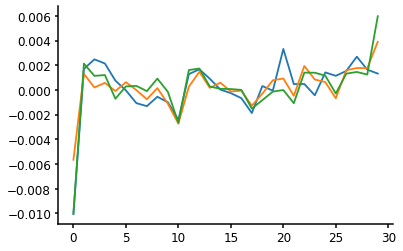

In [132]:
with mpl.rc_context(rc):
    plt.plot(np.array(thetas)[:,1:].transpose())
    plt.show()

In [118]:
reg_mod_vals=[]

### 4. Poisson non-linear model

In [43]:
[X_train, X_val, X_test, y_train, y_val, y_test] = cv_dt[0]
print(X_train.shape)
print(y_train.shape)
reg_mod = PoissonRegressor(
                alpha=0.1, 
                max_iter=10000
            )
reg_mod.fit(X_train, y_train)

(6141720, 30)
(6141720,)


PoissonRegressor(alpha=0.1, max_iter=10000)

In [45]:
from sklearn.metrics import log_loss

y_prob = reg_mod.predict_proba(X_test)
log_loss(y_test, y_prob)

AttributeError: 'PoissonRegressor' object has no attribute 'predict_proba'

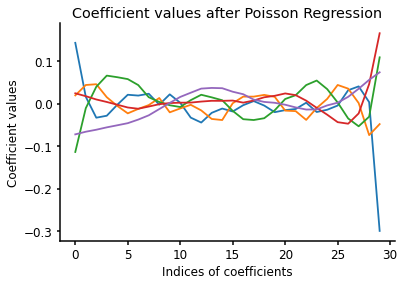

In [20]:
with mpl.rc_context(rc):
    plt.title("Coefficient values after Poisson Regression")
    #plt.title("STA over training data")
    plt.xlabel("Indices of coefficients")
    plt.ylabel("Coefficient values")
    plt.plot(reg_mod.coef_.transpose())
    #plt.plot(X_train[np.where(y_train>0)[0]].transpose().mean(axis=1))
    plt.show()

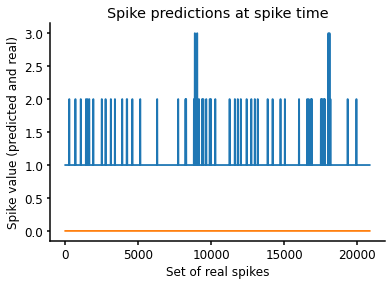

In [26]:
with mpl.rc_context(rc):
    plt.title("Spike predictions at spike time")
    plt.xlabel("Set of real spikes")
    plt.ylabel("Spike value (predicted and real)")
    plt.plot(y_val[np.where(y_val>0)[0]])
    #plt.plot(reg_mod.predict(X_val))
    plt.plot(reg_mod.predict(X_val[np.where(y_val>0)[0]]))
    plt.show()

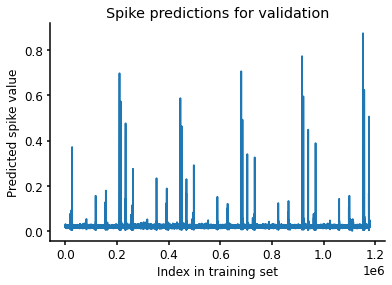

In [27]:
with mpl.rc_context(rc):
    plt.title("Spike predictions for validation")
    plt.xlabel("Index in training set")
    plt.ylabel("Predicted spike value")
    #plt.plot(y_val[np.where(y_val>0)[0]])
    plt.plot(reg_mod.predict(X_val))
    #plt.plot(reg_mod.predict(X_val[np.where(y_val>0)[0]]))
    plt.show()

In [43]:
sta = X_train[np.where(y_train>0)[0]].transpose().mean(axis=1)

In [64]:
# Define the model
#reg_mod = PoissonRegressor(alpha=0.5, max_iter=1000)

#reg_mod = LogisticRegression(penalty='l2', C=1/0.8)
model_type = "PoissonGLM"
scaler = "StandardScaler"
model_params = {'max_iter' : 1000000}
betas = np.arange(0.0, 1.0, 0.1)
#betas = np.array([0.0])
path = f"../experiments/grid_search_beta/{model_type}/{scaler}/gs_{channels}_{spike_type}_c{c}_b{bin_size}_beta_"

grid_cv_scores = fitter.grid_search_beta(
    model_type, 
    model_params, 
    betas, 
    cv_dt, 
    path
)



**** Performing CV for beta 0.0 ****
>>>>>>>>> Start Split 0
## FITTING ##
Score 0.012703417549487783
## VALIDATION ##
Score 0.01676822470708883
## TESTING ##
>>>>>>>>> End Split 0

>>>>>>>>> Start Split 1
## FITTING ##
Score 0.013289258126494174
## VALIDATION ##
Score 0.018392627941093753
## TESTING ##
>>>>>>>>> End Split 1

>>>>>>>>> Start Split 2
## FITTING ##
Score 0.014895585671563571
## VALIDATION ##
Score 0.008502074331082743
## TESTING ##
>>>>>>>>> End Split 2

>>>>>>>>> Start Split 3
## FITTING ##
Score 0.017381594606076023
## VALIDATION ##
Score 0.012630796089221685
## TESTING ##
>>>>>>>>> End Split 3


**** Performing CV for beta 0.1 ****
>>>>>>>>> Start Split 0
## FITTING ##
Score 0.011432959356080796
## VALIDATION ##
Score 0.014710431507725885
## TESTING ##
>>>>>>>>> End Split 0

>>>>>>>>> Start Split 1
## FITTING ##
Score 0.012168370463740974
## VALIDATION ##
Score 0.01689995172409431
## TESTING ##
>>>>>>>>> End Split 1

>>>>>>>>> Start Split 2
## FITTING ##
Score 0.0133

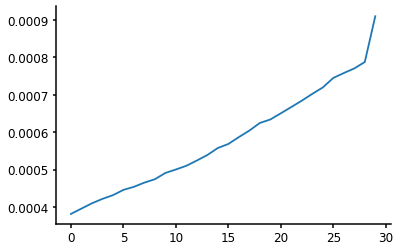

In [49]:
with mpl.rc_context(rc):
    plt.plot(sol[1][0][0].transpose())
    plt.show()

In [8]:
lnlp = LNL_POISSON()

beta = 0.0

thetas_lnlp = []
losses_lnlp = []
y_preds_lnlp = []

s = 0
for [X_train, X_val, X_test, y_train, y_val, y_test] in cv_dt: 
    print(f">>>>>>>>> Start Split {s}")
    print("## FITTING ##")
    theta_i, losses = lnlp.fit(X_train, y_train, beta)
    thetas_lnlp.append(theta_i)
    losses_lnlp.append(losses)
    
    print("## TESTING ##")
    y_pred_train = lnlp.predict(X_train, theta_i)
    y_pred_val = lnlp.predict(X_val, theta_i)    
    y_pred_test = gllnlpm.predict(X_test, theta_i)   
    y_preds_lnlp.append([y_pred_train, y_pred_val, y_pred_test])
    
    print(f">>>>>>>>> End Split {s}")
    s += 1

>>>>>>>>> Start Split 0
## FITTING ##
Iteration 0 with loss 12232406.25317885.
Iteration 1 with loss 12232406.071154037.
Iteration 2 with loss 12232406.238798372.
Iteration 3 with loss 12232406.238801034.
Iteration 4 with loss 12232406.267554387.
Iteration 5 with loss 12232406.267551797.
Iteration 6 with loss 12232406.267548904.
Iteration 7 with loss 12232406.238811847.
Iteration 8 with loss 12232406.238814307.
Iteration 9 with loss 12232406.238816326.
Iteration 10 with loss 12232406.238817763.
Iteration 11 with loss 12232406.238818025.
Iteration 12 with loss 12232406.267540338.
Iteration 13 with loss 12232406.238816017.
Iteration 14 with loss 12232406.238813858.
Iteration 15 with loss 12232406.238810834.
Iteration 16 with loss 12232406.238807125.


KeyboardInterrupt: 

In [ ]:
lnlp = LNL_POISSON()

beta = 0.0

thetas_lnlp = []
losses_lnlp = []
y_preds_lnlp = []

s = 0
for [X_train, X_val, X_test, y_train, y_val, y_test] in cv_dt: 
    print(f">>>>>>>>> Start Split {s}")
    print("## FITTING ##")
    theta_i, losses = lnlp.fit(X_train, y_train, beta)
    thetas_lnlp.append(theta_i)
    losses_lnlp.append(losses)
    
    print("## TESTING ##")
    y_pred_train = lnlp.predict(X_train, theta_i)
    y_pred_val = lnlp.predict(X_val, theta_i)    
    y_pred_test = gllnlpm.predict(X_test, theta_i)   
    y_preds_lnlp.append([y_pred_train, y_pred_val, y_pred_test])
    
    print(f">>>>>>>>> End Split {s}")
    s += 1
    

>>>>>>>>> Start Split 0
## FITTING ##
Iteration 0 with loss 12518222.485305922.
Iteration 5 with loss 12518222.469491668.
Iteration 10 with loss 12518222.469481718.
Iteration 15 with loss 12518222.469481712.
Iteration 20 with loss 12518222.469487688.
Iteration 25 with loss 12518222.469499405.
Iteration 30 with loss 12518222.469517816.
Iteration 35 with loss 4154239.5721834353.
Iteration 40 with loss 4154239.5721868062.
Iteration 45 with loss 4154239.5721905916.
Iteration 50 with loss 4154239.5721929017.
Iteration 55 with loss 4154239.5721925893.
Iteration 60 with loss 4154239.5721902796.
Iteration 65 with loss 2.7584969817516362e+193.
Iteration 70 with loss 2.758496899819889e+193.
Iteration 75 with loss 2.7584968997692783e+193.
Iteration 80 with loss 2.75849689981426e+193.
Iteration 85 with loss 2.7584968997687426e+193.
Iteration 90 with loss 2.758496899802924e+193.
Iteration 95 with loss 2.7584968999955954e+193.
Iteration 100 with loss 7.587771920413976e+64.
Iteration 105 with loss 7.

In [12]:
with mpl.rc_context(rc):
    plt.plot(np.array(thetas).transpose())
    plt.show()

[0.] [1. 1. 1. 1. 1.]
[0. 1. 1. 1. 1. 1.]


In [24]:
def neg_log_lik_lnp(theta, X, y):
    """Return -loglike for the Poisson GLM model.
    Args:
    theta (1D array): Parameter vector.
    X (2D array): Full design matrix.
    y (1D array): Data values.
    Returns:
    number: Negative log likelihood.
    """
    # Compute the Poisson log likelihood
    rate = np.exp(X @ theta)
    log_lik = y @ np.log(rate) - rate.sum()
    return -log_lik


def fit_lnp(lfps, spikes, d=25):
    """Obtain MLE parameters for the Poisson GLM.
    Args:
    lfps (2D array): LFP values in matrix
    spikes (1D array): Spike counts measured at each timepoint
    d (number): Number of time lags to use.
    Returns:
    1D array: MLE parameters
    """

    # Build the design matrix
    y = spikes
    constant = np.ones_like(y)
    X = np.column_stack([constant, X_train_stsc])
    #X = lfps

    # Use a random vector of weights to start (mean 0, sd .2)
    d = X.shape[1]
    x0 = np.random.normal(0, .2, d)

    # Find parameters that minmize the negative log likelihood function
    res = minimize(neg_log_lik_lnp, x0, args=(X, y))

    return res["x"]

In [27]:
# suppress warnings
#warnings.filterwarnings('ignore')

# Fit LNP model
theta_lnp = fit_lnp(X_train_stsc, y_train_stsc)

/tmp/ipykernel_3875859/1062663867.py:11: RuntimeWarning: overflow encountered in exp
  rate = np.exp(X @ theta)
/tmp/ipykernel_3875859/1062663867.py:12: RuntimeWarning: divide by zero encountered in log
  log_lik = y @ np.log(rate) - rate.sum()
/tmp/ipykernel_3875859/1062663867.py:12: RuntimeWarning: invalid value encountered in matmul
  log_lik = y @ np.log(rate) - rate.sum()
/tmp/ipykernel_3875859/1062663867.py:11: RuntimeWarning: overflow encountered in exp
  rate = np.exp(X @ theta)
/tmp/ipykernel_3875859/1062663867.py:12: RuntimeWarning: divide by zero encountered in log
  log_lik = y @ np.log(rate) - rate.sum()
/tmp/ipykernel_3875859/1062663867.py:12: RuntimeWarning: invalid value encountered in matmul
  log_lik = y @ np.log(rate) - rate.sum()
/tmp/ipykernel_3875859/1062663867.py:11: RuntimeWarning: overflow encountered in exp
  rate = np.exp(X @ theta)
/tmp/ipykernel_3875859/1062663867.py:12: RuntimeWarning: divide by zero encountered in log
  log_lik = y @ np.log(rate) - rate.s

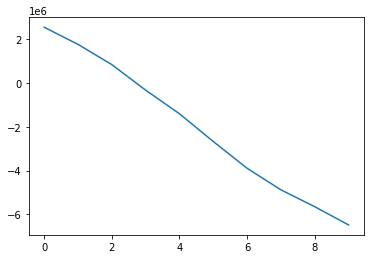

In [28]:
plt.plot(theta_lnp[1:])
plt.show()

In [29]:
y = y_train_stsc
constant = np.ones_like(y)
X = np.column_stack([constant, X_train_stsc])
y_pred_poission = np.exp(X @ theta_lnp)

/tmp/ipykernel_3875859/3558607474.py:4: RuntimeWarning: overflow encountered in exp
  y_pred_poission = np.exp(X @ theta_lnp)


### 5. Reguralization